In [1]:
# %reload_ext autoreload
# %autoreload 2
import numpy as np
import pandas as pd
import logging
import os
import os
import sys

log = lambda msg: logging.info(msg)

root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [3]:
from importlib import reload
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)
from models.eeg_states.eeg_states import load_and_prepare_settling_eeg_state_events
settling_events = load_and_prepare_settling_eeg_state_events()

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\google\cloud\firestore_v1\base_collection.py:300: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:133: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [4]:
display(settling_events['Preserve_SettlingManualScore'].value_counts())
display(settling_events['Preserve_SettlingV4ManualScore'].value_counts())
display(settling_events['Preserve_TiredVsAlertManualScore'].value_counts())
display(settling_events['Preserve_TiredVsAlertExtremesManualScore'].value_counts())

Preserve_SettlingManualScore
75     531
0      276
50     272
100    245
25     162
Name: count, dtype: int64

Preserve_SettlingV4ManualScore
0.0      170
25.0     162
75.0     107
100.0     70
Name: count, dtype: int64

Preserve_TiredVsAlertManualScore
100    776
0      710
Name: count, dtype: int64

Preserve_TiredVsAlertExtremesManualScore
0.0      276
100.0    245
Name: count, dtype: int64

## Load other data

In [5]:
import stitch_pipeline_results
# should_remove_days_per_questionnaire=False probably because the settling portion will usually be fine.
df = stitch_pipeline_results.stitch_all_days_optimised(input_dir, should_remove_days_per_questionnaire=False)

  0%|          | 0/161 [00:00<?, ?it/s]

c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (590) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (590) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  post_human_df = pd.read_csv(post_human_file)
c:\dev\Brainwave-Processor\stitch_pipeline_results.py:189: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  post_

In [6]:
df_orig = df.copy()
df['TimestampUK'] = df['Timestamp']

In [7]:
[col for col in df.columns if 'Tired' in col]

['SettlingTiredVsWiredPrediction', 'TiredVsAlertManualScore']

# Prepare data - find if in state

In [8]:
[]

[]

In [9]:
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)
from models.eeg_states.eeg_states import process_row
import pandas as pd
from tqdm import tqdm

# Pre-filter the data as it takes ages
first_timestamp_uk = settling_events['TimestampUK'].min()
filtered_yasa_df = df[df['Timestamp'] >= first_timestamp_uk]

# Add new columns to yasa_df to store the epoch type
yasa_df = filtered_yasa_df.copy() # defragment
# yasa_df['epoch_type'] = None
# yasa_df['matched_event'] = None

yasa_row = yasa_df.iloc[12]

# Test:
process_row(yasa_row, settling_events)

(event                                                                  tired
 version                                                                  NaN
 phase                                                                    NaN
 note                                                                     NaN
 source                                                                   NaN
 BaseEvent                                                              tired
 Preserve_SettlingEvent                                                 tired
 Preserve_SettlingEventVersion                                            NaN
 duration                                                                 NaT
 TimestampUK                                 2024-10-09 21:28:57.046000+01:00
 SinceUK                                                                  NaT
 dayAndNightOf                                                     2024-10-09
 Preserve_SettlingManualScore                                   

In [10]:


import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)
from models.eeg_states.eeg_states import add_event_type

# Note this is also applied in the post_human_pipeline
add_event_type(yasa_df, settling_events)


100%|██████████| 103054/103054 [00:56<00:00, 1835.24it/s]


In [11]:
display(yasa_df['TiredVsAlertExtremesManualScore'].value_counts())
display(yasa_df['SettlingV4ManualScore'].value_counts())
display(yasa_df['SettlingManualScore'].value_counts())
display(yasa_df['TiredVsAlertManualScore'].value_counts())


TiredVsAlertExtremesManualScore
0.0      519
100.0    329
Name: count, dtype: int64

SettlingV4ManualScore
0.0      374
25.0     259
75.0     135
100.0     86
Name: count, dtype: int64

SettlingManualScore
50.0     773
75.0     578
0.0      519
100.0    329
25.0     259
Name: count, dtype: int64

TiredVsAlertManualScore
0.0      1551
100.0     907
Name: count, dtype: int64

# EDA


In [27]:
import pandas as pd
import numpy as np

grouped_df = yasa_df.groupby('dayAndNightOf').agg(
    TiredVsAlertExtremesManualScoreCount=('TiredVsAlertExtremesManualScore', lambda x: len(x[x == 0]) + len(x[x == 100])),
    TiredVsAlertExtremesManualScore0=('TiredVsAlertExtremesManualScore', lambda x: len(x[x == 0])),
    TiredVsAlertExtremesManualScore100=('TiredVsAlertExtremesManualScore', lambda x: len(x[x == 100])),
).reset_index()
grouped_df

,dayAndNightOf,TiredVsAlertExtremesManualScoreCount,TiredVsAlertExtremesManualScore0,TiredVsAlertExtremesManualScore100
0,2024-10-09,0,0,0
1,2024-10-11,0,0,0
2,2024-10-15,0,0,0
3,2024-10-20,23,23,0
4,2024-10-21,0,0,0
...,...,...,...,...
88,2025-02-26,0,0,0
89,2025-02-27,0,0,0
90,2025-03-01,0,0,0
91,2025-03-05,0,0,0


In [12]:
# Explore datafrom memory import garbage_collect

garbage_collect(log)

NameError: name 'garbage_collect' is not defined

In [13]:
import models.eeg_states.eeg_states_model
reload(models.eeg_states.eeg_states_model)
from models.eeg_states.eeg_states_model import tired_vs_wired_model_pipeline

models_and_data = [
    tired_vs_wired_model_pipeline('settling-extremes-tired-vs-wired', yasa_df, "TiredVsAlertExtremesManualScore", False),
    # # tired_vs_wired_model_pipeline('settling-score', yasa_df, "SettlingManualScore", False),
    # # tired_vs_wired_model_pipeline('settling-v4-score', yasa_df, "SettlingV4ManualScore", False),
    # tired_vs_wired_model_pipeline('settling-tired-vs-wired', yasa_df, "TiredVsAlertManualScore", False),
]

['Main_eeg_abspow_s', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_beta_c7min_norm_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_betaabs_c7min_norm_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_db_c7min_norm_s', 'Main_eeg_

# Explore data

In [14]:
from models.eeg_states.eeg_states_model import ModelAndData
from sklearn.model_selection import train_test_split

unique_days = df['dayAndNightOf'].unique()
# Take a random 10% of the days for testing
test_days, train_days = train_test_split(unique_days, test_size=0.9, random_state=42)

print(f"Training on {len(train_days)} days, testing on {len(test_days)} days")

def split(modelAndData: ModelAndData):
    temp_X = modelAndData.X.copy()
    temp_y = modelAndData.y.copy()
    temp_X['dayAndNightOf'] = df['dayAndNightOf']

    train_mask = temp_X['dayAndNightOf'].isin(train_days)
    test_mask = temp_X['dayAndNightOf'].isin(test_days)

    temp_X.drop(columns=['dayAndNightOf'], inplace=True)

    modelAndData.X_train = temp_X[train_mask]
    modelAndData.y_train = temp_y[train_mask]
    modelAndData.X_val = temp_X[test_mask]
    modelAndData.y_val = temp_y[test_mask]

# def split(modelAndData: ModelAndData):
#     X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.1, random_state=42)
#     modelAndData.X_train = X_train_to_sleep
#     modelAndData.y_train = y_train_to_sleep
#     modelAndData.X_val = X_val_to_sleep
#     modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    print(md.name)
    # Identify columns with null values
    # null_columns = md.X.columns[md.X.isnull().any()]
    #
    # # Count the number of null values in each column
    # null_counts = md.X[null_columns].isnull().sum()
    #
    # # Print the columns with null values and their counts
    # print("Columns with null values and their counts:")
    # print(null_counts)
    #
    # # Inspect the rows with null values
    # rows_with_nulls = md.X[md.X.isnull().any(axis=1)]
    # print("Rows with null values:")
    # print(rows_with_nulls)
    # assert(len(md.X) > 0)
    # assert not md.X.isnull().values.any(), "DataFrame contains NaN values"
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training on 127 days, testing on 14 days
settling-extremes-tired-vs-wired
Training set size settling-extremes-tired-vs-wired: 703, validation set size: 145



/;~# Train Catboost model

In [ ]:
import models.util.importances as importances
reload(importances)

import models.util.rfe_training as training
reload(training)
import copy

import memory

memory.garbage_collect(print)

train_list = []
train_list.append({"type": "XGBoost", "rfe": True, "supportsFeatureWeights": True})


for md in models_and_data:
    models = []
    for tl in train_list:
        if tl.get('requireRemovedNan', False) and not md.removed_nan:
            continue

        tl_copy = copy.deepcopy(tl)
        if (tl['type'] == 'XGBoost'):
            tl_copy['type'] = 'XGBoostClassifier'

        rfe = tl.get('rfe', False)
        models.extend(training.train_rfe(training.get_model, tl_copy, md.name, md.X_train, md.y_train, md.X_val, md.y_val, rfe))
    md.models = models

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)
pd.set_option('display.max_columns', None)

display(evaluation.evaluate_regression_models(models_and_data))
display(evaluation.evaluate_classification_models(models_and_data))


Memory Usage: 1849.34 MB GC to 1849.34 MB
Training XGBoostClassifier model for settling-extremes-tired-vs-wired with (703, 141)

XGBoostError: [11:23:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`

: 

## Evaluate the model

Evaluation for model:  settling-score-non-realtime
settling-score-non-realtime Training Set Evaluation:
MAE: 1.091670956734561, MSE: 2.1116924497070126, RMSE: 1.4531663530742145


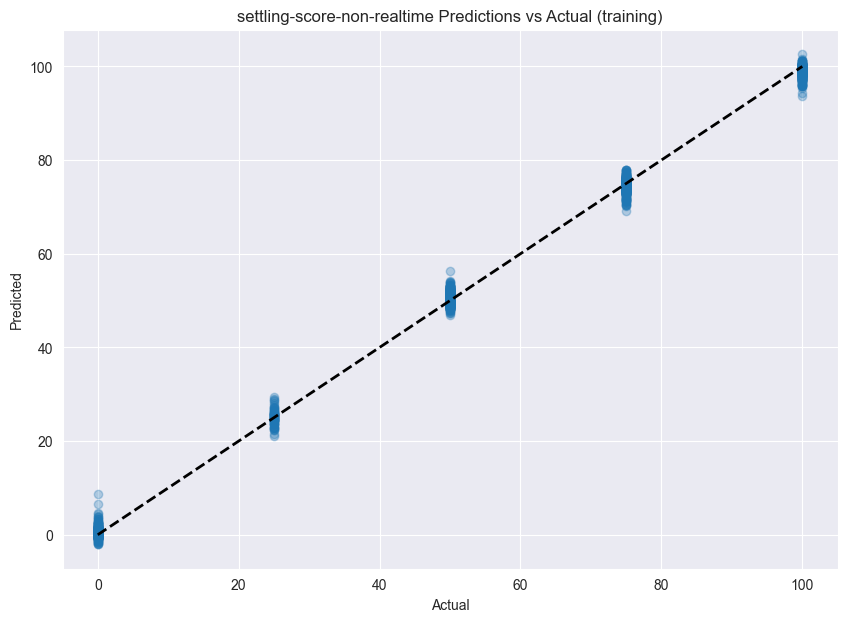

settling-score-non-realtime Validation Set Evaluation:
MAE: 9.057312551606039, MSE: 189.7756873522944, RMSE: 13.775909674220951


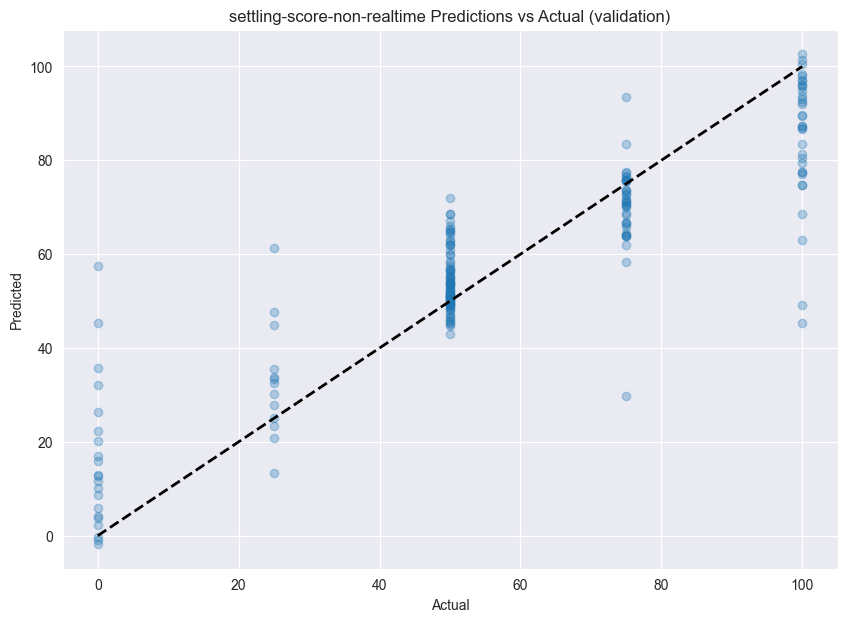

Evaluation for model:  settling-score-realtime
settling-score-realtime Training Set Evaluation:
MAE: 3.294912540425535, MSE: 18.675711310445575, RMSE: 4.321540386302733


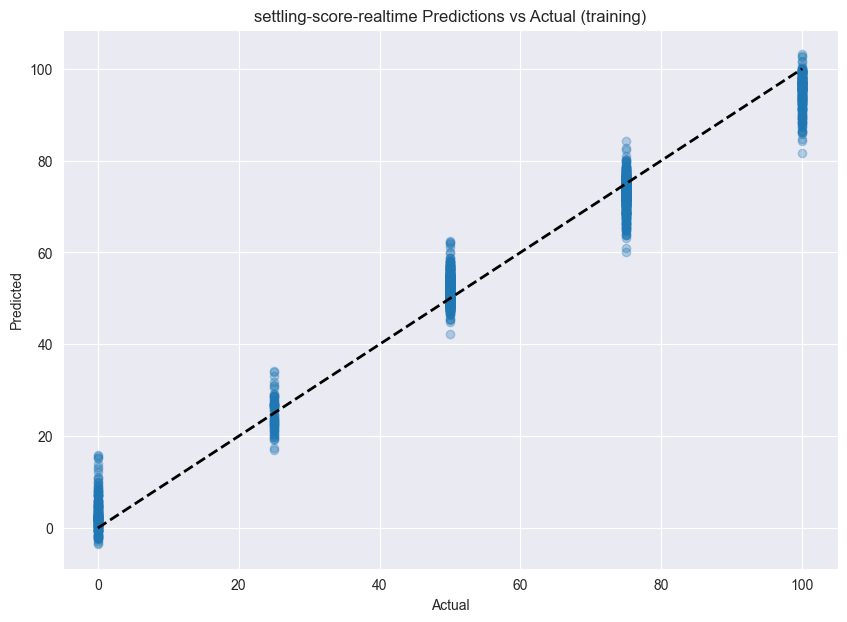

settling-score-realtime Validation Set Evaluation:
MAE: 14.143877944144572, MSE: 360.8133264822756, RMSE: 18.99508690378319


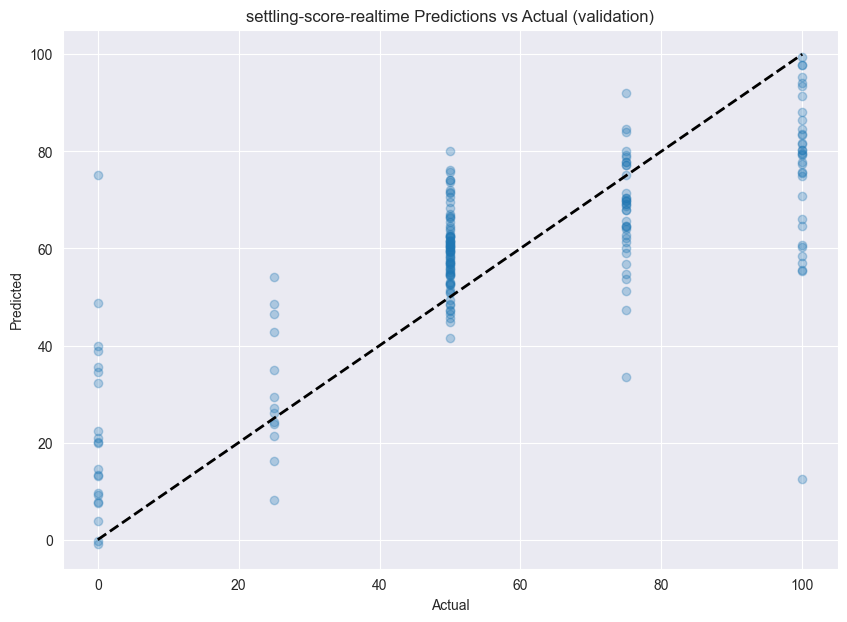

Evaluation for model:  settling-v4-score-non-realtime
settling-v4-score-non-realtime Training Set Evaluation:
MAE: 0.012068599722612176, MSE: 0.0002005758543159008, RMSE: 0.01416248051422846


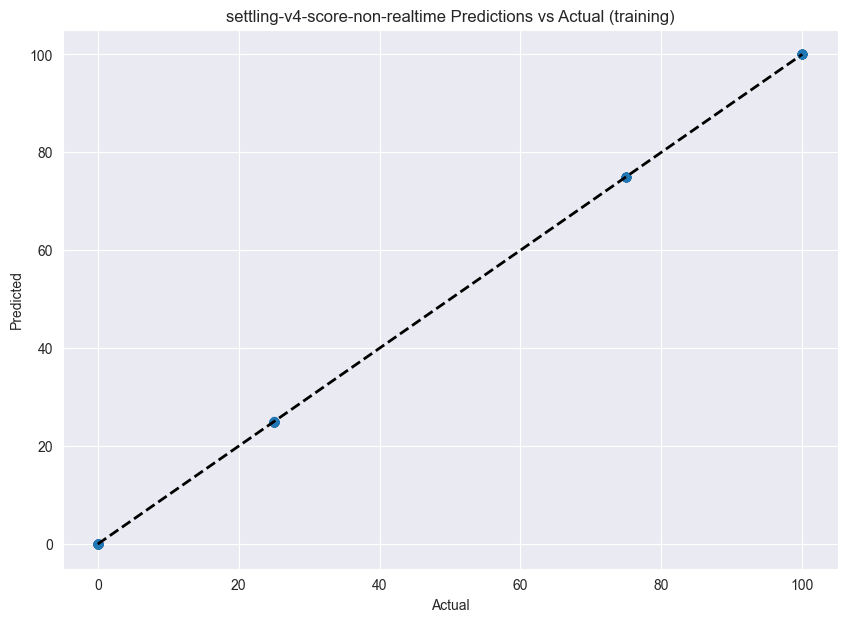

settling-v4-score-non-realtime Validation Set Evaluation:
MAE: 9.159349288256251, MSE: 204.58969803211681, RMSE: 14.30348552039386


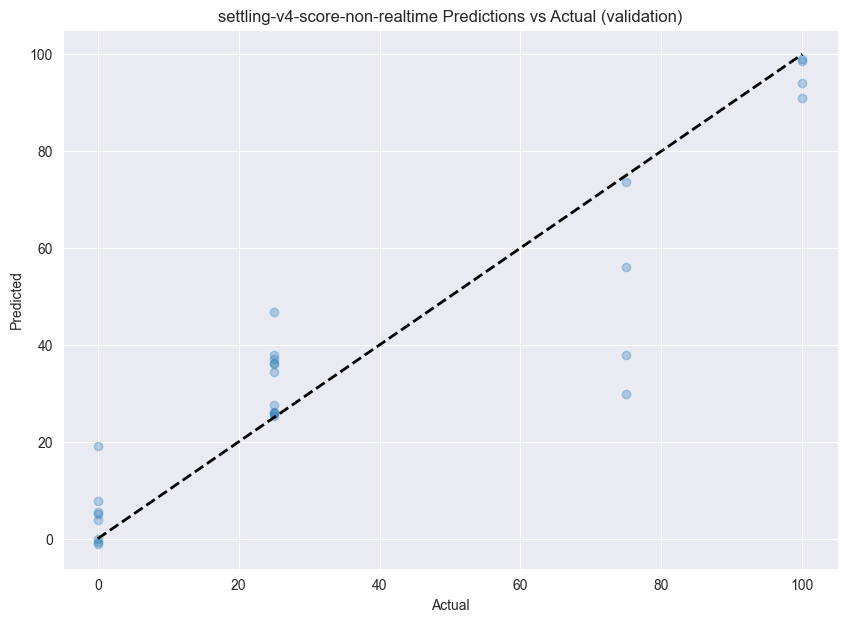

Evaluation for model:  settling-v4-score-realtime
settling-v4-score-realtime Training Set Evaluation:
MAE: 0.05273141042679849, MSE: 0.004071278046121029, RMSE: 0.06380656742155175


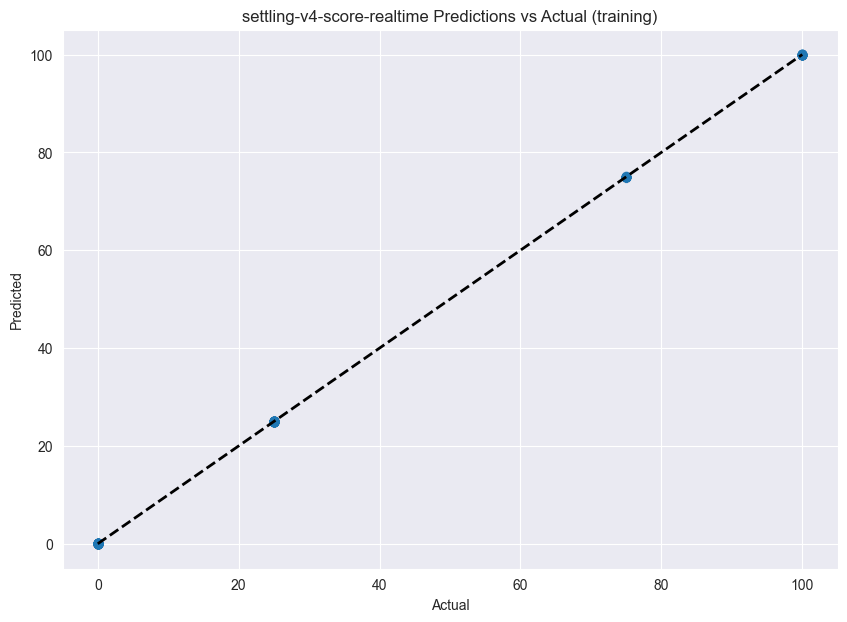

settling-v4-score-realtime Validation Set Evaluation:
MAE: 12.235669485645076, MSE: 258.48897300324415, RMSE: 16.077592263869743


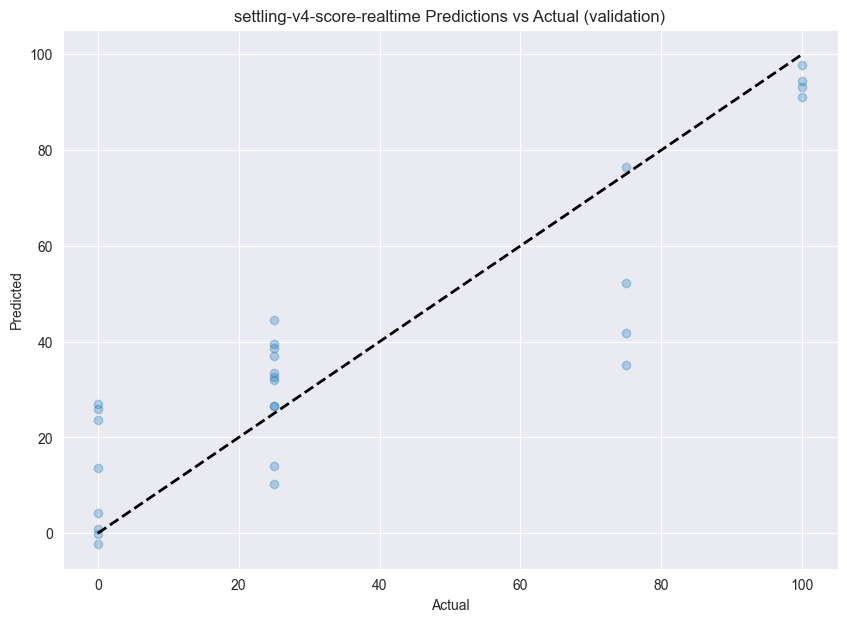

Evaluation for model:  settling-tired-vs-wired-non-realtime
settling-tired-vs-wired-non-realtime Training Set Evaluation:
MAE: 2.1488318165442832, MSE: 8.521648754872473, RMSE: 2.919186317259053


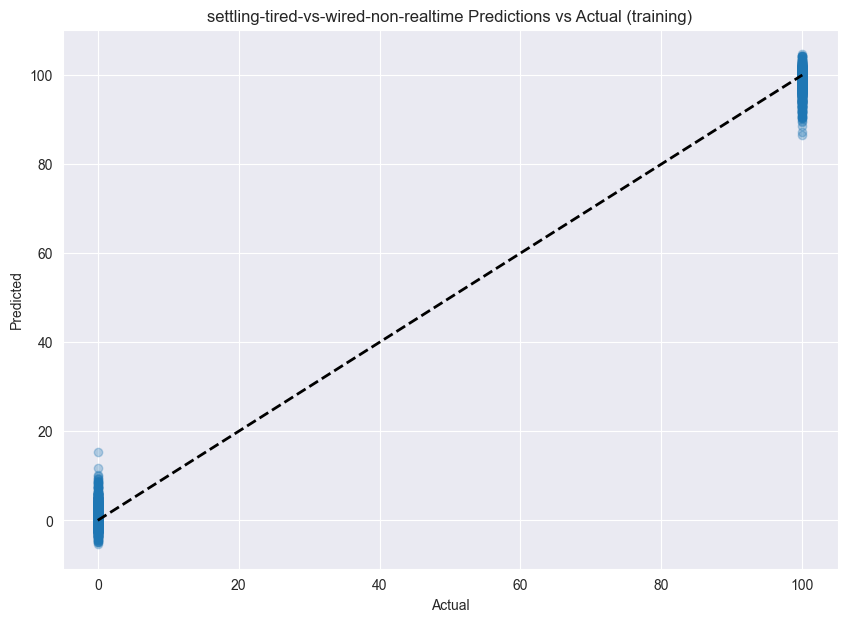

settling-tired-vs-wired-non-realtime Validation Set Evaluation:
MAE: 16.60534856033014, MSE: 530.0404680708456, RMSE: 23.022607760000724


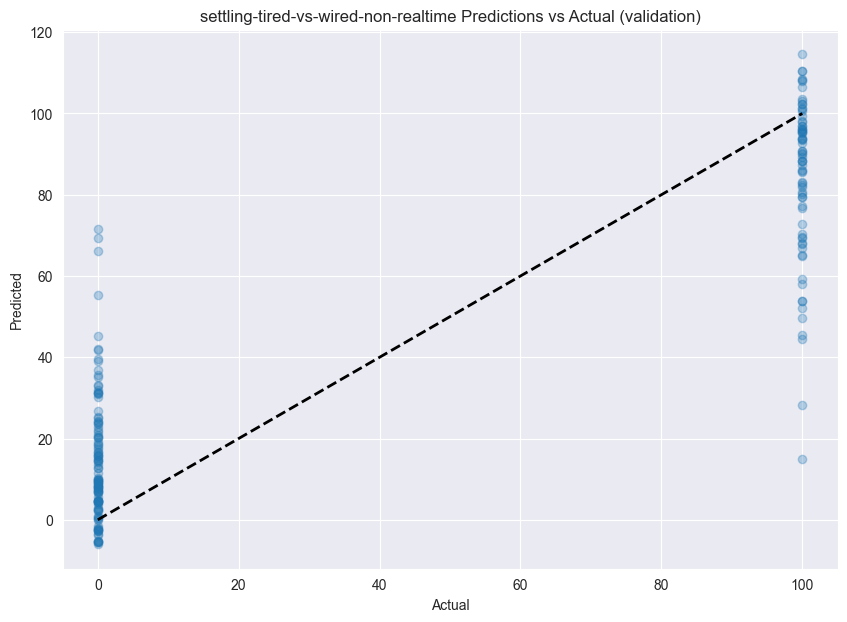

Evaluation for model:  settling-tired-vs-wired-realtime
settling-tired-vs-wired-realtime Training Set Evaluation:
MAE: 6.460028490992517, MSE: 71.93304468615672, RMSE: 8.481335076870664


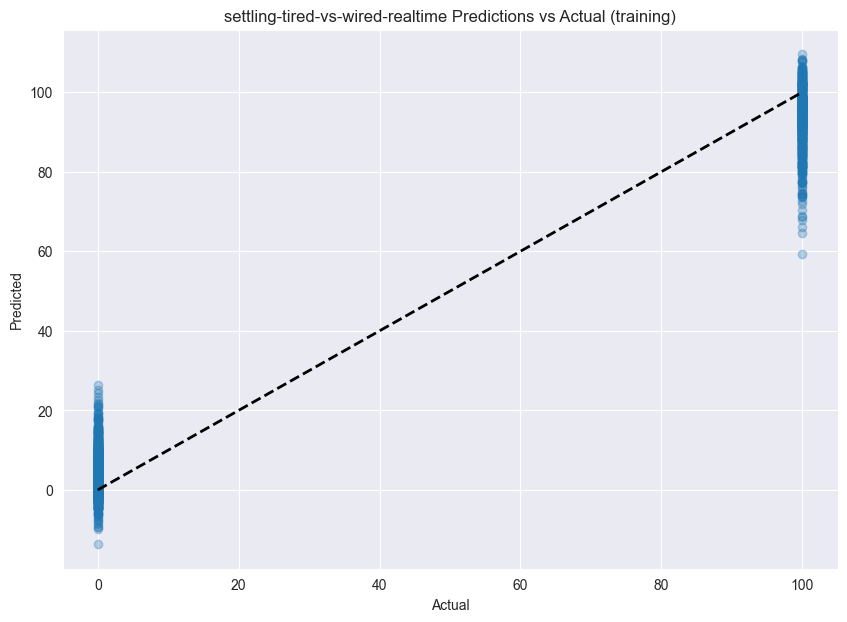

settling-tired-vs-wired-realtime Validation Set Evaluation:
MAE: 27.270669547568417, MSE: 1182.8116557111339, RMSE: 34.39202895601151


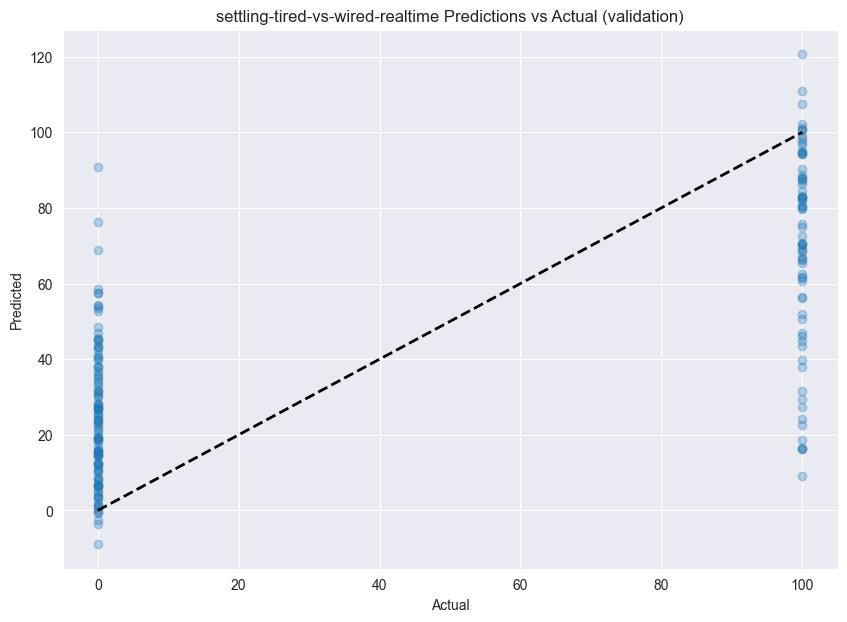

In [28]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def evaluate_classification_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)

    val_train = model.predict(X_train)

    train_results_df = pd.DataFrame({
        'Actual': y_train,
        'Predicted': val_train
    })

    cm_train = confusion_matrix(train_results_df['Actual'], train_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (training)')
    plt.show()

    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    print(val_predictions)
    
    # Create a DataFrame with y_val and the predictions
    val_results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions
    })

    cm_val = confusion_matrix(val_results_df['Actual'], val_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (validation)')
    plt.show()

def evaluate_regression_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)

    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_predictions = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    print(f"MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}")

    plt.figure(figsize=(10, 7))
    plt.scatter(y_train, train_predictions, alpha=0.3)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (training)')
    plt.show()

    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_predictions = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    print(f"MAE: {val_mae}, MSE: {val_mse}, RMSE: {val_rmse}")

    # Plot the predictions vs actual values for the validation set
    plt.figure(figsize=(10, 7))
    plt.scatter(y_val, val_predictions, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (validation)')
    plt.show()
    
for md in models_and_data:
    evaluate_regression_model(md, md.X_train, md.y_train, md.X_val, md.y_val)

## Most useful features

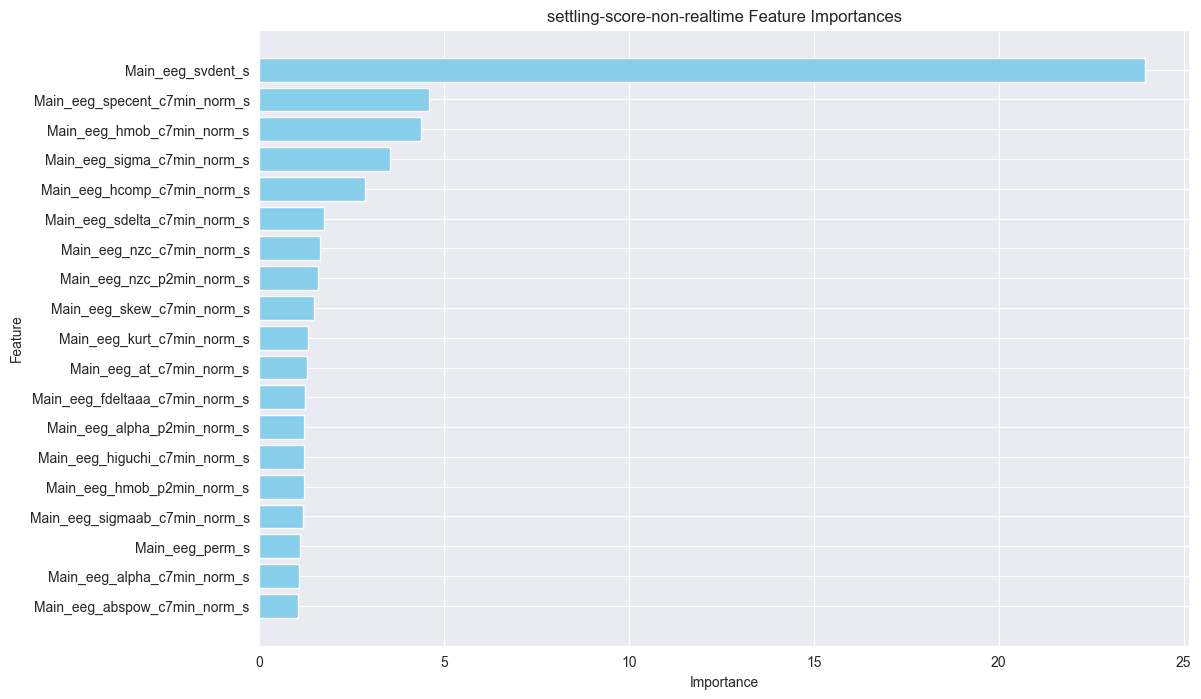

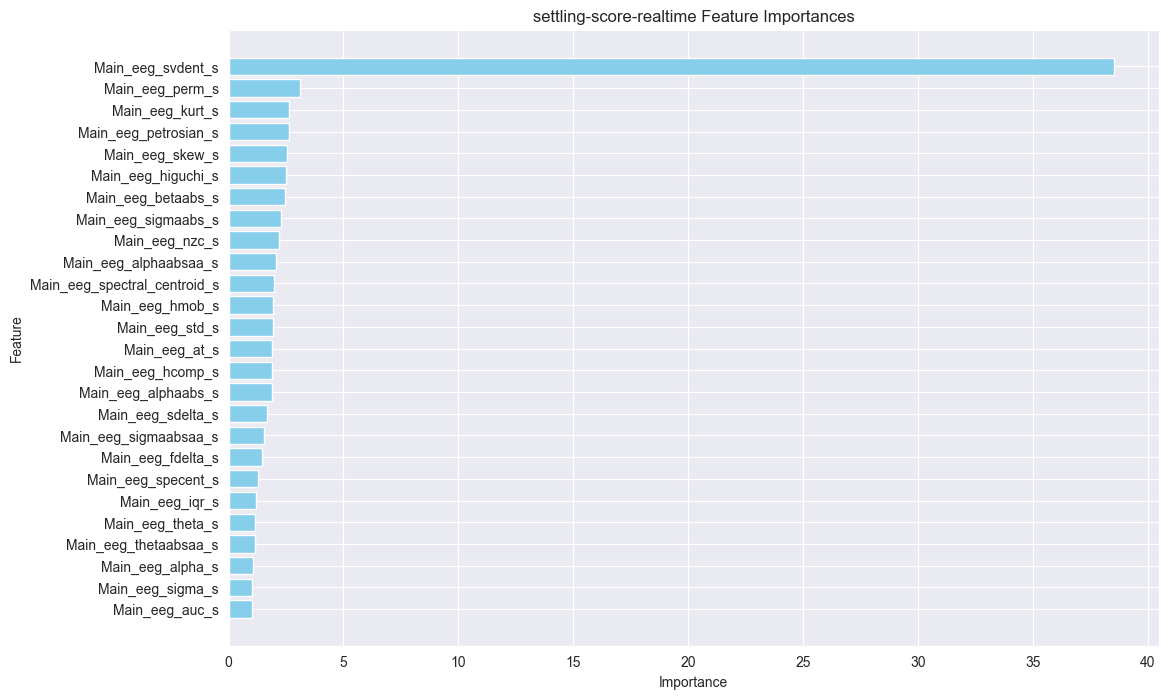

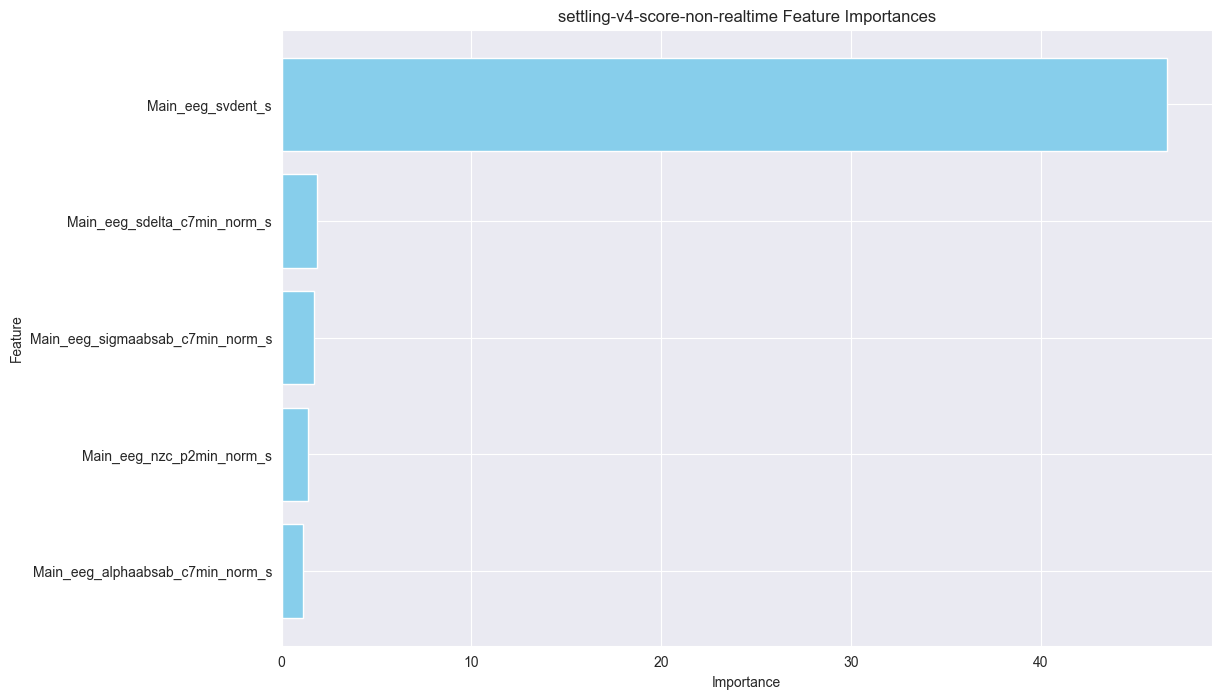

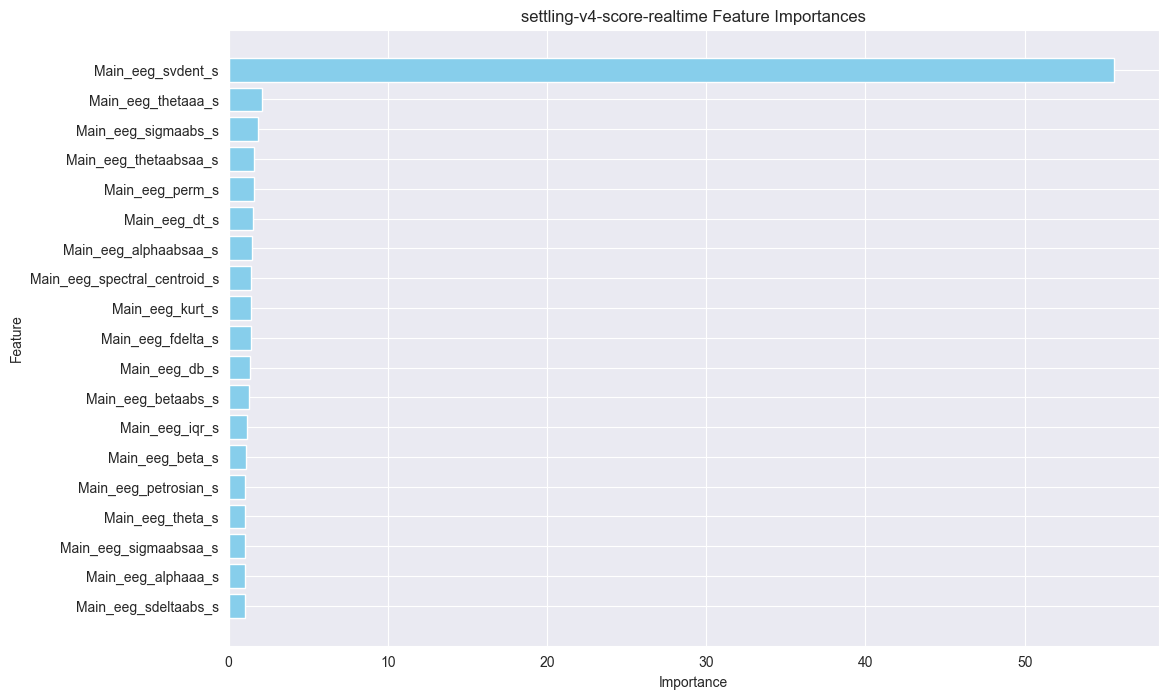

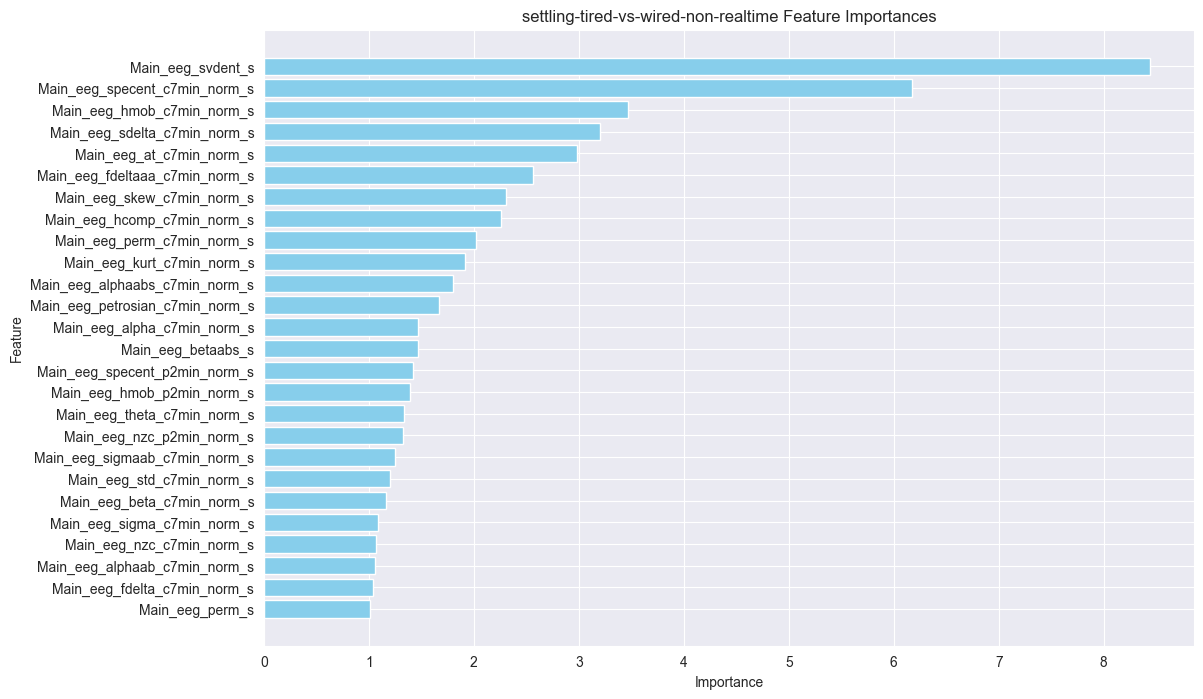

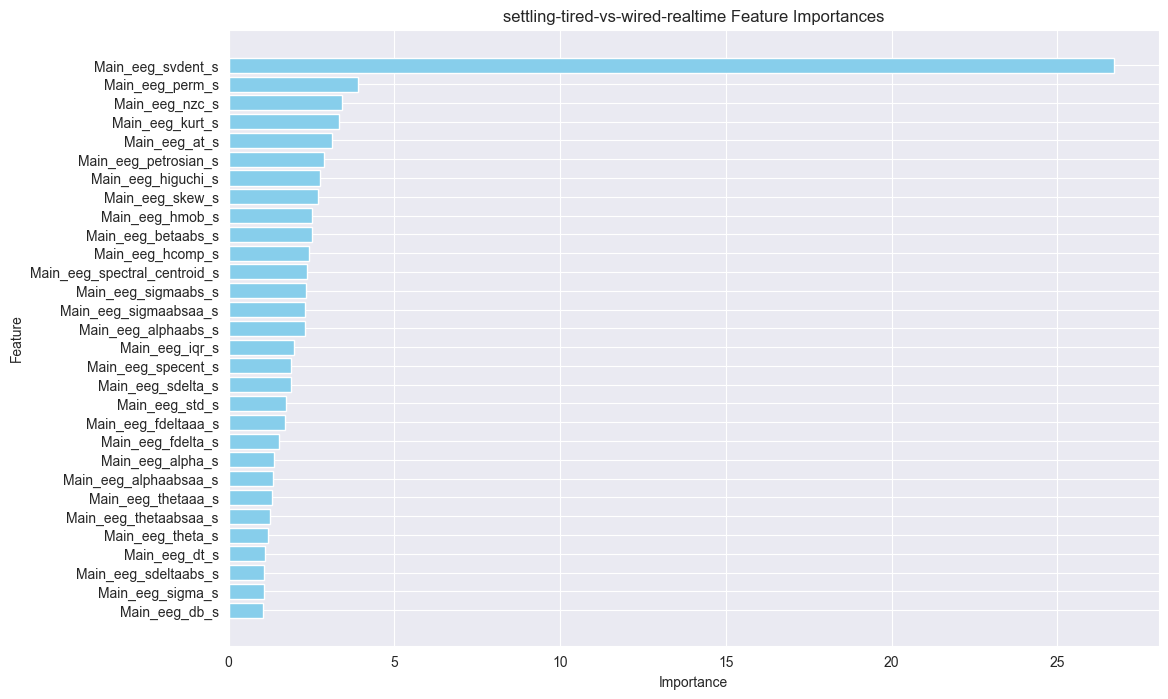

In [29]:
# import pandas as pd
import matplotlib.pyplot as plt

def importances(md: ModelAndData):
    # Get feature importances
    feature_importances = md.model.get_feature_importance()
    
    # Create a DataFrame to display the feature importances
    feature_names = md.X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df[importance_df['Importance'] > 1]
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(md.name + ' Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

for md in models_and_data:
    importances(md)

# Save model

In [30]:
import dotenv
dotenv.load_dotenv()

import paramiko

# Configure logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

def secure_copy_file(local_path, remote_path, hostname, username, password):
    # Create an SSH client
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    ssh.connect(hostname, username=username, password=password)

    # Open an SFTP session
    sftp = ssh.open_sftp()

    # Get the size of the file to be transferred
    file_size = os.path.getsize(local_path)

    # Define a callback function to show progress
    with tqdm(total=file_size, unit='B', unit_scale=True, desc=local_path) as pbar:
        def progress_callback(transferred, total):
            pbar.update(transferred - pbar.n)

        # Copy the file with progress callback
        sftp.put(local_path, remote_path, callback=progress_callback)

    # Close the SFTP session and SSH connection
    sftp.close()
    ssh.close()

hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')

for md in models_and_data:
    model_filename = f"{md.name}_catboost_model.cbm"
    md.model.save_model(model_filename)
    secure_copy_file(model_filename, '/home/graham/dev/Brainwave-Models/' + model_filename, hostname, username, password)

print("Copied all files")

settling-score-non-realtime_catboost_model.cbm: 100%|██████████| 2.25M/2.25M [00:00<00:00, 3.22MB/s]
settling-score-realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 6.01MB/s]
settling-v4-score-non-realtime_catboost_model.cbm: 100%|██████████| 2.25M/2.25M [00:00<00:00, 6.05MB/s]
settling-v4-score-realtime_catboost_model.cbm: 100%|██████████| 2.23M/2.23M [00:00<00:00, 5.44MB/s]
settling-tired-vs-wired-non-realtime_catboost_model.cbm: 100%|██████████| 2.25M/2.25M [00:00<00:00, 6.31MB/s]
settling-tired-vs-wired-realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 6.04MB/s]

Copied all files
